# Image analysis grid

In this noebook we aim to segment the image, so that we can get individual squares with one digit in it (or none) to then pass to the ML algorithm in order torecognise said digit.

The steps are:

* read in the images
* convert to grayscale
* adaptive threshold
* Hough transform to get the lines
* Identify where the lines intercepts


In [1]:
# imports

import os
import numpy as np
from skimage import io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import math
import scipy.misc
from skimage.filters import threshold_niblack, threshold_sauvola
from skimage.transform import hough_line, hough_line_peaks
%matplotlib inline

## Set up folder

In [2]:
# set up folders
#imageDataDir = 'C:\\Users\\tequi\\Documents\\repos\\sudoku_dataset\\images\\'
imageDataDir = 'C:\\Users\\JOSA\\Documents\\imagesRepo\\sudoku_dataset\\images\\'

allImages = []
for file in os.listdir(imageDataDir):
    if file.endswith(".jpg"):
        allImages.append(file)

## To grayscale

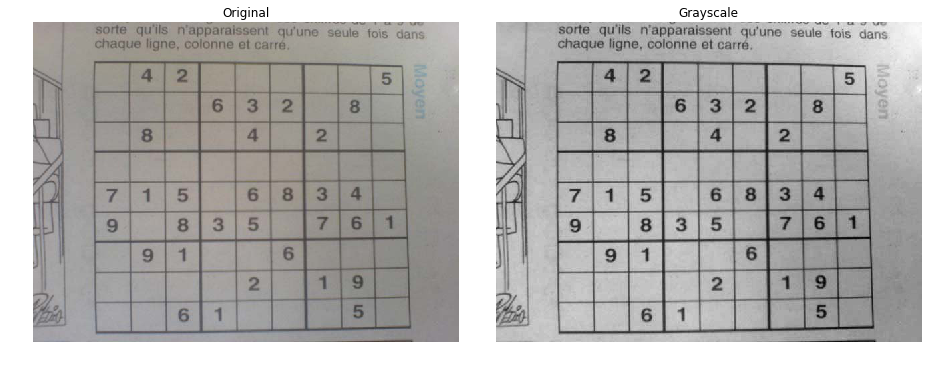

In [3]:
#open 1 image and convert it grayscale
idxToOpen = 1
filename = os.path.join(imageDataDir, allImages[idxToOpen])
imgOr = io.imread(filename)
img = rgb2gray(imgOr)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
ax = axes.ravel()

ax[0].imshow(imgOr)
ax[0].set_title("Original")
ax[0].set_axis_off()
ax[1].imshow(img, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")
ax[1].set_axis_off()

fig.tight_layout()
plt.show()

## Thresholding

We consider the `niblack` and the `sauvola` methods. The `niblack` seems better for now, so it will be kept in the rest of the markdown.

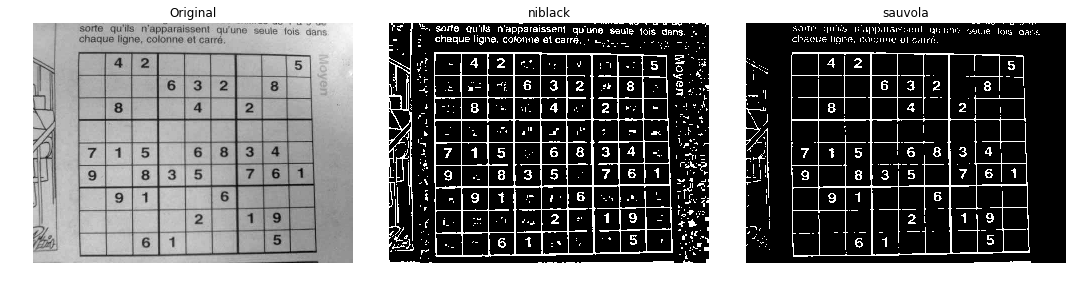

In [4]:
# masking (adaptive threshold)


window_size = 25
k = 0.8
thresh_niblack = threshold_niblack(img, window_size=window_size, k=k)
thresh_sauvola = threshold_sauvola(img, window_size=window_size)

binary_niblack = img < thresh_niblack
binary_sauvola = img < thresh_sauvola

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title("Original")
ax[0].set_axis_off()
ax[1].imshow(binary_niblack, cmap=plt.cm.gray)
ax[1].set_title("niblack")
ax[1].set_axis_off()
ax[2].imshow(binary_sauvola, cmap=plt.cm.gray)
ax[2].set_title("sauvola")
ax[2].set_axis_off()

fig.tight_layout()
plt.show()


## Hough transform

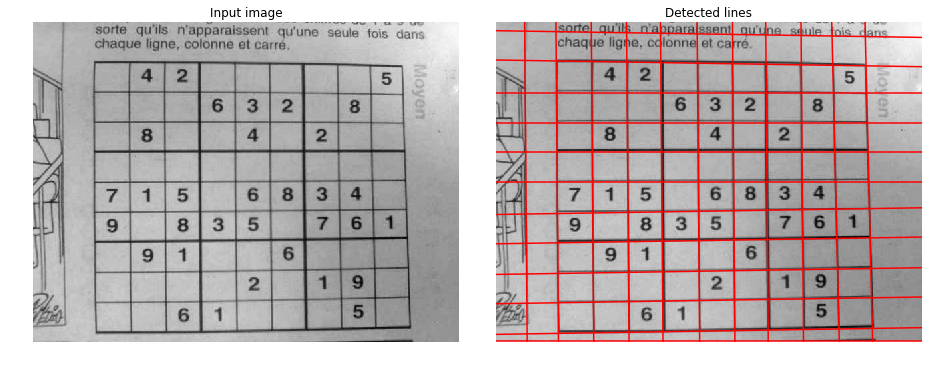

In [5]:
# hough
# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 200)

h, theta, d = hough_line(binary_niblack, theta=tested_angles)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(img, cmap=plt.cm.gray)
origin = np.array((0, img.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r')
ax[1].set_xlim(origin)
ax[1].set_ylim((img.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

plt.tight_layout()
plt.show()

## Get lines and intercepts

the basic idea is to create an array of 0s with same dimensions as the image. All the `[row, col]` corresponding to pixels were a line is will be assigned a value of 1. Intercepts points will have a final value > 1.

In [6]:
#black grid
blackGrid = np.zeros((img.shape[0], img.shape[1]))

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    if y0 < 0 or y1 > img.shape[0]:
        # this deals with vertical lines, using the equation of a line to
        # get the corresponding points fitting inside the figure coordinates space
        mLine = (y0-y1)/(origin[0]-origin[1])
        qLine = y0
        #when y=0 and y = (img height)-1
        y0 = 0
        y1 = img.shape[0]-2
        x0 = int(round((y0-qLine)/mLine))
        x1 = int(round((y1-qLine)/mLine))
    else :
        x0 = 0
        x1 = img.shape[1]-1
        y1 = y1-2
         # ugly piece of code to deal with going out of array index
        if y0 > img.shape[0]-1:
            y0 = img.shape[0]-1
        if y1 > img.shape[0]-1:
            y1 = img.shape[0]-1
            
    #this converts plot coordinates to array coordinates
    nPoints = int(round(math.sqrt(img.shape[0]**2+img.shape[1]**2)))
    #linespace to get all values between the plot ([x0, y0], [x1, y1]) coordinates
    allRows = list(map(int, np.ndarray.tolist(np.round(np.linspace(y0, y1, nPoints),0))))
    allCols = list(map(int, np.ndarray.tolist(np.round(np.linspace(x0, x1, nPoints),0))))
    #assign +1 to all points in the 0s array where aline is
    blackGrid[allRows, allCols] = blackGrid[allRows, allCols] + 1
 
#find the intercepts were the 0s grid is > 1
interceptsGrid = np.zeros((img.shape[0], img.shape[1]))
interceptsGrid[blackGrid > 1] = 1

# note: the image displayed does not show well the lines. Check the saved image for a beter representation
scipy.misc.toimage(blackGrid).save('blackGrid.jpg')
scipy.misc.toimage(interceptsGrid).save('interceptsGrid.jpg')
scipy.misc.toimage(img).save('originalImg.jpg')


C:\Users\JOSA\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
C:\Users\JOSA\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
C:\Users\JOSA\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


## Verify approach for multiple images